In [22]:
import numpy as np
import os
import struct
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [23]:
def load_emnist_images(file_path):
    with open(file_path, 'rb') as f:
        _, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

In [24]:
def load_emnist_labels(file_path):
    with open(file_path, 'rb') as f:
        _, num = struct.unpack('>II', f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

In [25]:
# ---- Step 2: Preprocess Images ----
def preprocess_images(images):
    images = np.transpose(images, (0, 2, 1))  # Rotate 90 CCW
    images = np.flip(images, axis=2)         # Flip horizontally
    images = images / 255.0
    images = np.expand_dims(images, -1)      # Add channel dimension
    return images


In [26]:
# ---- Step 3: Augment Dataset with Flipped Classes ----
def augment_with_flipped_classes(images, labels):
    num_classes = len(np.unique(labels))
    flipped_images = np.flip(images, axis=2)
    flipped_labels = labels + num_classes

    all_images = np.concatenate([images, flipped_images], axis=0)
    all_labels = np.concatenate([labels, flipped_labels], axis=0)
    is_flipped = np.array([0] * len(images) + [1] * len(images))
    return all_images, all_labels, is_flipped


In [27]:
def create_dataset(images, labels, flip_flags, num_classes_total, batch_size=128):
    labels_cat = tf.keras.utils.to_categorical(labels, num_classes_total)
    flip_flags = np.array(flip_flags).astype(np.float32).reshape(-1, 1)
    
    dataset = tf.data.Dataset.from_tensor_slices((
        images.astype(np.float32),
        {
            'class_output': labels_cat,
            'flip_output': flip_flags
        }
    ))
    
    return dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [28]:
# ---- Step 5: Build Model ----
def build_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)

    class_output = layers.Dense(num_classes, activation='softmax', name='class_output')(x)
    flip_output = layers.Dense(1, activation='sigmoid', name='flip_output')(x)

    model = models.Model(inputs=inputs, outputs=[class_output, flip_output])
    model.compile(
        optimizer='adam',
        loss={
            'class_output': 'categorical_crossentropy',
            'flip_output': 'binary_crossentropy'
        },
        metrics={
            'class_output': 'accuracy',
            'flip_output': 'accuracy'
        }
    )
    return model


In [29]:
def predict_and_correct(model, images, label_to_char):
    preds_class, preds_flip = model.predict(images)
    pred_labels = np.argmax(preds_class, axis=1)
    flip_flags = (preds_flip > 0.5).astype(int).flatten()

    corrected_preds = []
    num_classes_total = preds_class.shape[1]
    for i, pred in enumerate(pred_labels):
        base_class = pred % (num_classes_total // 2)
        char = label_to_char[base_class]
        corrected_preds.append((char, flip_flags[i]))
    return corrected_preds


In [31]:
# ---- Step 7: Load and Run ----
base_path = 'D:/Dyslexia_app/mnist_model/emnist_source_files'
train_images = load_emnist_images(os.path.join(base_path, 'emnist-balanced-train-images-idx3-ubyte'))
train_labels = load_emnist_labels(os.path.join(base_path, 'emnist-balanced-train-labels-idx1-ubyte'))
test_images = load_emnist_images(os.path.join(base_path, 'emnist-balanced-test-images-idx3-ubyte'))
test_labels = load_emnist_labels(os.path.join(base_path, 'emnist-balanced-test-labels-idx1-ubyte'))


In [32]:
# Remap sparse labels to 0–(N–1)
unique_labels = np.unique(train_labels)
num_classes = len(unique_labels)           # 94 original characters
num_classes_total = num_classes * 2        # 188 (with flipped versions)

label_map = {orig: i for i, orig in enumerate(unique_labels)}
inv_label_map = {i: orig for orig, i in label_map.items()}

train_labels = np.array([label_map[l] for l in train_labels])
test_labels = np.array([label_map[l] for l in test_labels])


In [33]:
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

mapping_file = os.path.join(base_path, '..', 'emnist-balanced-mapping.txt')
mapping = np.loadtxt(mapping_file, dtype=int)
# Rebuild label_to_char using remapped indices
label_to_char = {}
for orig, ascii_code in mapping:
    if orig in label_map:
        new_idx = label_map[orig]
        label_to_char[new_idx] = chr(ascii_code)


aug_train_images, aug_train_labels, train_is_flipped = augment_with_flipped_classes(train_images, train_labels)
aug_test_images, aug_test_labels, test_is_flipped = augment_with_flipped_classes(test_images, test_labels)


In [34]:
num_classes = len(unique_labels)
num_classes_total = num_classes * 2  # Total due to flipped labels

train_ds = create_dataset(aug_train_images, aug_train_labels, train_is_flipped, num_classes_total)
test_ds = create_dataset(aug_test_images, aug_test_labels, test_is_flipped, num_classes_total)

model = build_model(train_images.shape[1:], num_classes_total)

model.fit(train_ds, validation_data=test_ds, epochs=10)

Epoch 1/10
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 112s 59ms/step - class_output_accuracy: 0.6528 - class_output_loss: 1.2503 - flip_output_accuracy: 0.9889 - flip_output_loss: 0.0366 - loss: 1.2869 - val_class_output_accuracy: 0.4424 - val_class_output_loss: 2.9864 - val_flip_output_accuracy: 0.5000 - val_flip_output_loss: 3.5960 - val_loss: 6.5866
Epoch 2/10
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 153s 87ms/step - class_output_accuracy: 0.8081 - class_output_loss: 0.6040 - flip_output_accuracy: 0.9815 - flip_output_loss: 0.0708 - loss: 0.6748 - val_class_output_accuracy: 0.4878 - val_class_output_loss: 2.3969 - val_flip_output_accuracy: 0.5000 - val_flip_output_loss: 3.0142 - val_loss: 5.4144
Epoch 3/10
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 146s 83ms/step - class_output_accuracy: 0.8320 - class_output_loss: 0.5130 - flip_output_accuracy: 0.9824 - flip_output_loss: 0.0641 - loss: 0.5771 - val_class_output_accuracy: 0.5231 - val_class_output_loss: 2.1448 - val_flip_output_accuracy: 0.5000 - val_flip_output_los

In [37]:
def show_predictions(images, labels, is_flipped):
    preds = predict_and_correct(model, images[:16], label_to_char)
    for i in range(16):
        plt.imshow(images[i].squeeze(), cmap='gray')
        true_char = label_to_char[labels[i] % num_classes]
        pred_char, flipped = preds[i]
        plt.title(f"True: {true_char} | Pred: {pred_char} | Flipped: {flipped}")
        plt.axis('off')
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


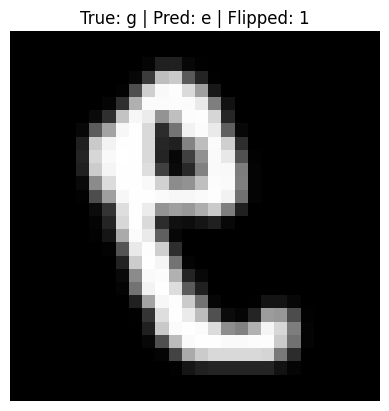

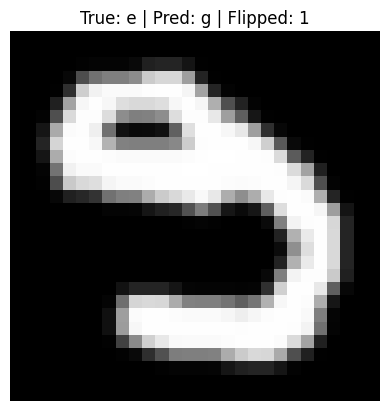

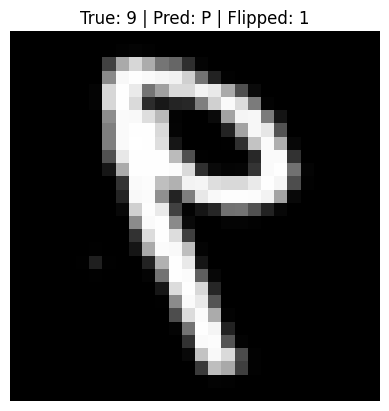

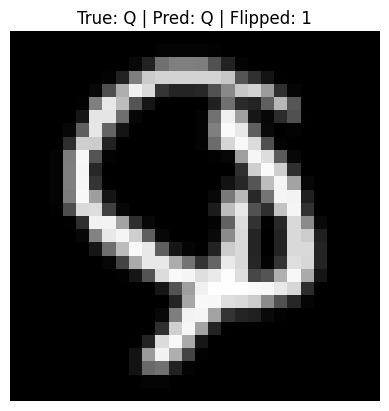

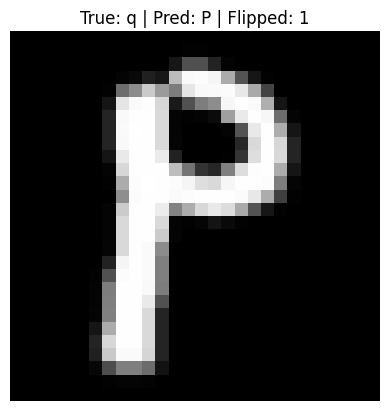

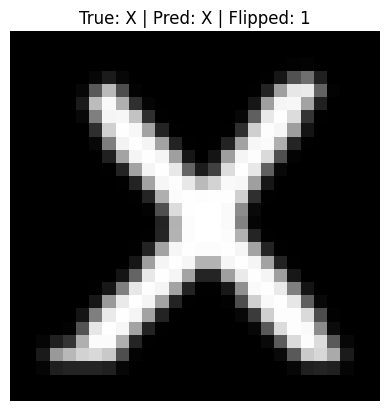

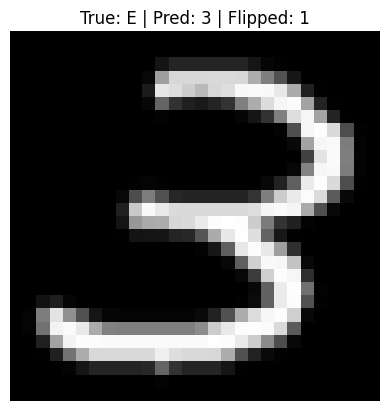

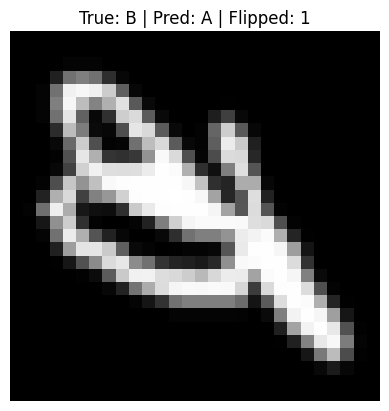

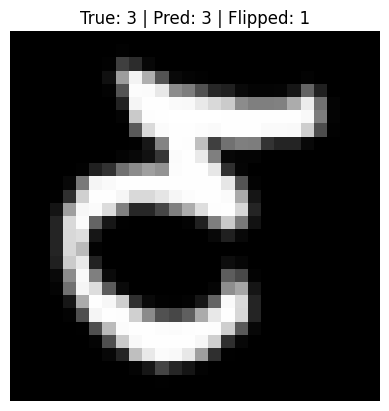

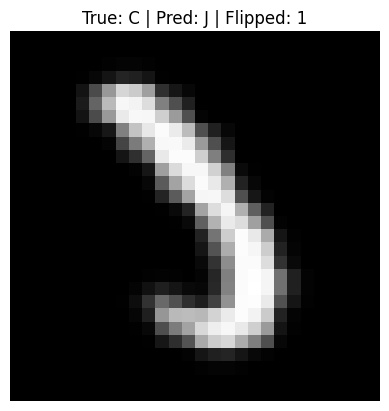

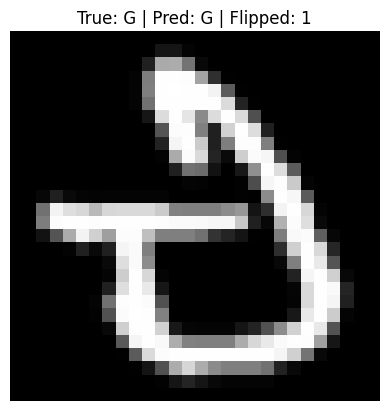

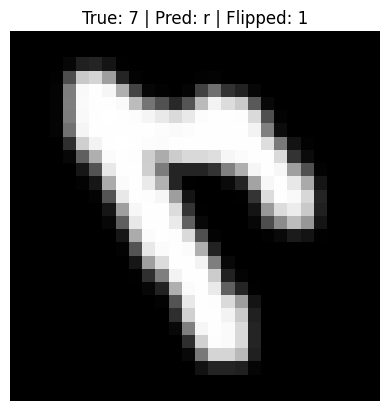

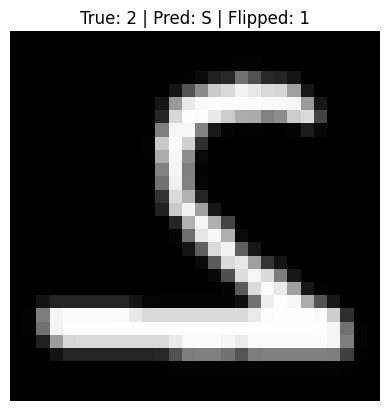

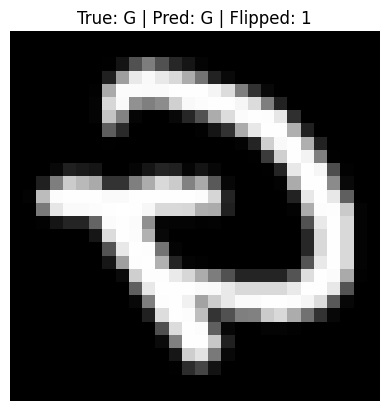

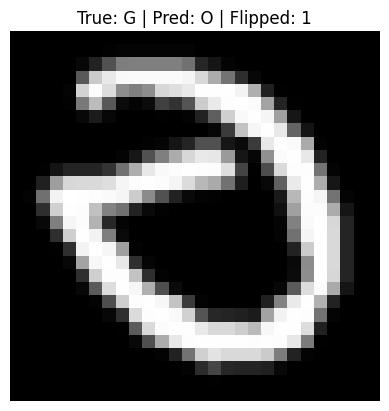

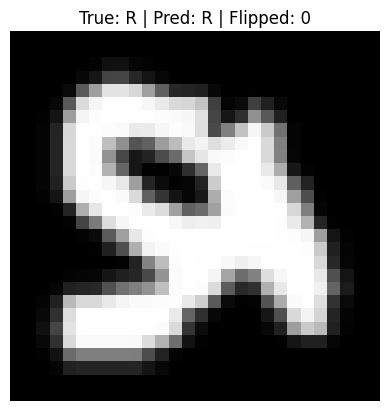

In [38]:
show_predictions(aug_test_images, aug_test_labels, test_is_flipped)

In [39]:
from PIL import Image
import numpy as np

def load_custom_image(path, size=(28, 28)):
    img = Image.open(path).convert('L')     # Convert to grayscale
    img = img.resize(size)                  # Resize to 28x28
    img = np.array(img)
    img = 255 - img                         # Invert: black character on white → white character on black
    img = img / 255.0                       # Normalize
    img = np.expand_dims(img, axis=(0, -1)) # Shape: (1, 28, 28, 1)
    img = np.transpose(img, (0, 2, 1, 3))   # Match EMNIST orientation
    img = np.flip(img, axis=2)              # Flip horizontally
    return img.astype(np.float32)


In [40]:
def predict_custom_image(image, model, label_to_char):
    preds = predict_and_correct(model, image, label_to_char)
    pred_char, is_flipped = preds[0]
    print(f"Predicted character: {pred_char} | Flipped: {is_flipped}")
    plt.imshow(image[0].squeeze(), cmap='gray')
    plt.title(f"Predicted: {pred_char} | Flipped: {is_flipped}")
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Predicted character: 1 | Flipped: 1


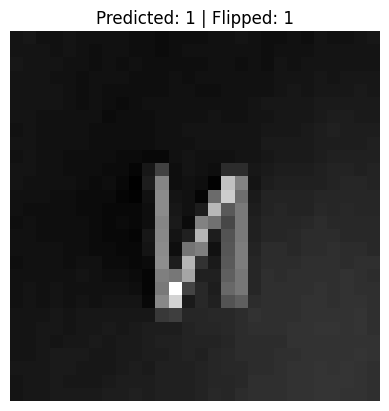

In [41]:
custom_img = load_custom_image("ulta_Z.jpg")  # or .jpg
predict_custom_image(custom_img, model, label_to_char)

In [42]:
model.save("flipped_emnist_classifier.h5")
